## X-Ray Diffraction Implementation

Python implementation of the virtual x-ray diffraction pattern algorithm, from http://dx.doi.org/10.1007/s11837-013-0829-3 and implemented in LAMMPS (in C++); https://github.com/lammps/lammps/tree/lammps-icms/src/USER-DIFFRACTION 

"This algorithm advances beyond previous virtual diffraction methods by using a high-resolution mesh of reciprocal space that eliminates the need for a priori knowledge of the crystal structure being modeled or other assumptions concerning the diffraction conditions. At each point on the reciprocal space mesh, the diffraction intensity is computed via explicit computation of the structure factor equation."

"X-ray diffraction line profiles are created by binning the intensity of each reciprocal lattice point by its associated scattering angle, effectively mimicking powder diffraction conditions."

The algorithm proceeds in the following manner:

1. Define a crystal structure by position (x,y,z) and atom/ion type.
2. Define the x-ray wavelength to use
3. Compute the full reciprocal lattice mesh
4. Filter reciprocal lattice points by those in the Eswald's sphere
5. Compute the structure factor at each reciprocal lattice point, for each atom type
6. Compute the x-ray diffraction intensity at each reciprocal lattice point
7. Group and sum intensities by angle

## Create a crystal structure and wavelength to analyse

In [212]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from IPython.display import Image
import ipymd
print ipymd.version()

0.4.2


In [213]:
data = ipymd.data_input.crystal.Crystal()
data.setup_data(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na1+', 'Cl1-'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])

meta = data.get_meta_data()
print meta
atoms_df = data.get_atom_data()
atoms_df.head(2)

origin                                 (0.0, 0.0, 0.0)
a                                     (27.0, 0.0, 0.0)
b                       (1.65327317885e-15, 27.0, 0.0)
c         (1.65327317885e-15, 1.65327317885e-15, 27.0)
dtype: object


,id,type,x,y,z,transparency,color,radius
0,1,Na1+,0.000000e+00,0.0,0.0,1.0,light_salmon,1.0
1,2,Na1+,3.306546e-16,2.7,2.7,1.0,light_salmon,1.0


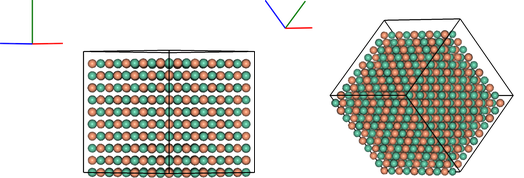

In [214]:
vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_axes()
vis2.add_box(*meta[['a','b','c','origin']])
vis2.add_atoms(atoms_df)
images = [vis2.get_image(xrot=xrot,yrot=45) for xrot in [0,45]]
vis2.visualise(images, columns=2)

Define wavelength of incident x-ray (Cu $k\alpha$ radiation)

In [215]:
wlambda = 1.5405 # Angstrom ()

In [216]:
import numpy as np
a=[1,0,0]
b=[0,1,0]
c=[0,0,1]

a_recip = np.cross(b,c)/(np.dot(a,np.cross(b,c)))
b_recip = np.cross(c,a)/(np.dot(a,np.cross(b,c)))
c_recip = np.cross(a,b)/(np.dot(a,np.cross(b,c)))

print a_recip
print b_recip
print c_recip

print np.dot(c,b)
print np.dot(c_recip,a_recip)

print ipymd.atom_analysis.basic.lattparams_bb([a_recip,b_recip,c_recip])

[1 0 0]
[0 1 0]
[0 0 1]
0
0
(1.0, 1.0, 1.0, 90.0, 90.0, 90.0)


In [217]:
import ipymd
data = ipymd.data_input.crystal.Crystal()
data.setup_data(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4,90,90,90])
meta = data.get_meta_data()
meta

origin                              (0.0, 0.0, 0.0)
a                                   (5.4, 0.0, 0.0)
b                      (3.3065463577e-16, 5.4, 0.0)
c         (3.3065463577e-16, 3.3065463577e-16, 5.4)
dtype: object

In [218]:
import numpy as np
a=meta.a#[1,0,0]
b=meta.b#[0,1,0]
c=meta.c#[0,0,1]

a_recip = np.cross(b,c)/(np.dot(a,np.cross(b,c)))
b_recip = np.cross(c,a)/(np.dot(a,np.cross(b,c)))
c_recip = np.cross(a,b)/(np.dot(a,np.cross(b,c)))

print a_recip
print b_recip
print c_recip

print map(np.linalg.norm,(a_recip,b_recip,c_recip))

print np.dot(c,b)
print np.dot(c_recip,a_recip)

print ipymd.atom_analysis.basic.lattparams_bb([a_recip,b_recip,c_recip])

[  1.85185185e-01  -1.13393222e-17  -1.13393222e-17]
[  0.00000000e+00   1.85185185e-01  -1.13393222e-17]
[ 0.          0.          0.18518519]
[0.18518518518518517, 0.18518518518518517, 0.18518518518518517]
1.78553503316e-15
-2.09987448413e-18
(0.18518518518518517, 0.18518518518518517, 0.18518518518518517, 90.0, 90.0, 90.0)


## Calculate full reciprocal lattice mesh

In [219]:
def set_thetas(min2theta=1.,max2theta=179.):
    """ set min and max angles to assess

    Properties
    ----------
    min2theta : float
        minimum 2 theta range to explore (degrees)
    max2theta : float
        maximum 2 theta range to explore (degrees)
    
    Returns
    -------
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)

    """
    # Process angles
    min_theta = math.radians(min2theta) / 2.
    max_theta = math.radians(max2theta) / 2.
    return min_theta, max_theta

In [220]:
def compute_rmesh(sim_abc, wlambda, min_theta, max_theta,
                  rspace=[1,1,1], periodic=[True,True,True], manual=False):
    """Compute full reciprocal lattice mesh, can deal with non-periodic directions, but not triclinic
    
    Properties
    ----------
    sim_abc : numpy.array((3,3))
        a,b,c cell vectors (length units)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)
    rspace : list of floats
        parameters to multiply the spacing of the reciprocal lattice nodes 
        in the h, k, and l directions respectively
    periodic : list of bools
        whether periodic boundary in the h, k, and l directions respectively
    manual : bool
        use manual spacing of reciprocal lattice points based on the values of the c parameters 
        (good for comparing diffraction results from multiple simulations, but small c required).
        
    Returns
    -------
    rmesh : np.array((N,3))
        mesh of k points defining reciprocal lattice
    
    """
    # get cell parameters
    a,b,c,alpha,beta,gamma = ipymd.atom_analysis.basic.lattparams_bb(sim_abc)
    cell_lengths = (a,b,c)
    if alpha!=90 or beta!=90 or gamma!=90:
        raise ValueError("This compute XRD does not work with triclinic structures")
    
    # maximum reciprocal lattice vector |K|, 
    # calculated from Bragg's law 
    Kmax = 2 * math.sin(max_theta) / wlambda 
        
    # Calculate spacing between reciprocal lattice points
    # Using distance based on periodic repeating distance
    if manual:
        inv_cell_lengths = [1.0,1.0,1.0]
    else:
        if not np.any(periodic):
            raise ValueError("Compute XRD must have at least one periodic boundary unless manual spacing specified")
        
        # calc inverse dimension for periodic directions
        inv_cell_lengths = [1/cell_lengths[i] if periodic[i] else np.nan for i in range(3)]
        ave_inv = np.nanmean(inv_cell_lengths)

        # Use the average inverse dimensions for non-periodic directions
        inv_cell_lengths = [icl if periodic[i] else ave_inv for i,icl in enumerate(inv_cell_lengths)]
        
    # resolution (i.e. spacing) of reciprocal space points
    dK = [inv_cell_lengths[i] * rspace[i] for i in range(3)]
    # maximum integer value for K points in each dimension
    Knmax = [math.ceil(Kmax / dK[i]) for i in range(3)]
    
    # create the full reprocal lattice indices grid
    rmesh = np.mgrid[-Knmax[0]:Knmax[0]+1:1, 
               -Knmax[1]:Knmax[1]+1:1, 
               -Knmax[1]:Knmax[1]+1:1].reshape(3,-1).T
    
    # resize reciprocal mesh to correct spacing
    for i in range(3):
        rmesh[:,i] *= dK[i]
    
    return rmesh

In [221]:
def compute_rmesh_triclininc(sim_abc, wlambda, min_theta, max_theta):
    """Compute full reciprocal lattice mesh
    
    Properties
    ----------
    sim_abc : numpy.array((3,3))
        a,b,c cell vectors (length units)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)
        
    Returns
    -------
    rmesh : np.array((N,3))
        mesh of k points defining reciprocal lattice
    
    """        
    # maximum reciprocal lattice vector |K|, 
    # calculated from Bragg's law 
    Kmax = 2 * math.sin(max_theta) / wlambda 
        
    # Calculate the rimitive reciprocal lattice vectors
    a,b,c = sim_abc
    a_recip = np.cross(b,c)/(np.dot(a,np.cross(b,c)))
    b_recip = np.cross(c,a)/(np.dot(a,np.cross(b,c)))
    c_recip = np.cross(a,b)/(np.dot(a,np.cross(b,c)))
    
    recip_lengths = map(np.linalg.norm, [a_recip,b_recip,c_recip])
        
    # maximum integer value for K points in each dimension
    Knmax = [math.ceil(Kmax / recip_lengths[i]) for i in range(3)]
    
    # create the full reciprocal lattice indices grid
    imesh = np.mgrid[-Knmax[0]:Knmax[0]+1:1, 
               -Knmax[1]:Knmax[1]+1:1, 
               -Knmax[1]:Knmax[1]+1:1].reshape(3,-1).T
    
    # calulate reciprocal lattice
    rmesh = (np.einsum('j,i->ji',imesh[:,0],a_recip) + 
             np.einsum('j,i->ji',imesh[:,1],b_recip) + 
             np.einsum('j,i->ji',imesh[:,2],c_recip)) 
    
    return rmesh

(4913, 3) -1.48148148148 1.48148148148


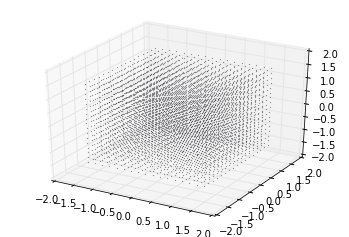

In [222]:
min_theta, max_theta = set_thetas()
rmesh = compute_rmesh(np.array([meta.a,meta.b,meta.c]),wlambda,min_theta, max_theta)
print rmesh.shape, rmesh.min(),rmesh.max()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rmesh[:,0],rmesh[:,1],rmesh[:,2],
           s=0.1,marker='.',c='blue',depthshade=False)
plt.show()

## Restrict reciprocal mesh to Ewald's sphere

$\left| {\mathbf{K}} \right| = \frac{1}{{d_{\text{hkl}} }} = \frac{2\sin \left( \theta \right)}{\lambda } $

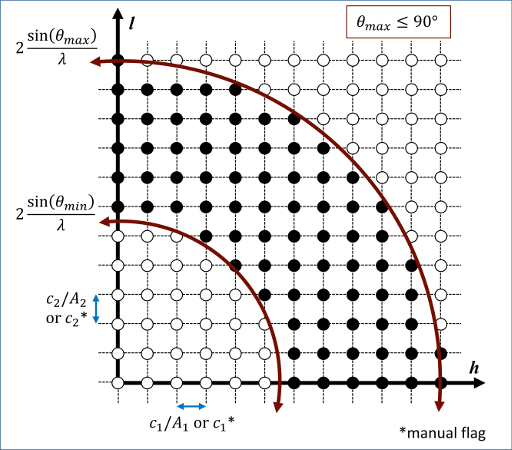

In [223]:
Image('xrd_mesh.jpg',width=300)

In [224]:
def restrict_rmesh(rmesh, wlambda, min_theta, max_theta):
    """filter mesh points to only those in Eswald's sphere 
    (and angular limits)
    
    Parameters
    ----------
    rmesh : np.array((N,3))
        mesh of k points defining reciprocal lattice
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min_theta : float
        minimum theta range to explore (radians)
    max_theta : float
        maximum theta range to explore (radians)

    Returns
    -------
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    k_mods : np.array((N,1))
         modulus for each k-point
    thetas : np.array((N,1))
        angles for each k-point (radians)

    """
    # calculate the length (squared) of each mesh vector
    K_sqr = np.sum(np.square(rmesh),axis=1)
    # select only mesh points within the Eswald sphere radius
    radius_mask = K_sqr * wlambda**2 <= 2**2 # i.e. (2sin(pi))^2
    # calculate the angle of each remaining mesh vector
    K = np.sqrt(K_sqr[radius_mask])
    theta = np.arcsin(wlambda * np.sqrt(K_sqr[radius_mask]) * 0.5)
    # select only mesh points within the angular limits
    angle_mask = np.logical_and(theta <= max_theta, theta >= min_theta)
    # return remaining mesh points
    return rmesh[radius_mask][angle_mask], K[angle_mask], theta[angle_mask]

1418


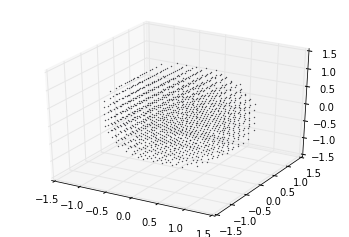

In [225]:
rmesh_sphere, k_mods, thetas = restrict_rmesh(rmesh,wlambda,min_theta, max_theta)
print len(rmesh_sphere)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rmesh_sphere[:,0],rmesh_sphere[:,1],rmesh_sphere[:,2],
           s=0.1,depthshade=False)
plt.show()

## Calculate the structure factors for each reciprocal mesh point

The atomic scattering factors, fj, accounts for the reduction in diffraction intensity due to Compton scattering. 

$f_j \left(\frac{\sin \theta}{\lambda}\right) = \left[ \sum\limits^4_i a_i \exp \left( -b_i \frac{\sin^2 \theta}{\lambda^2} \right)\right] + c = \left[ \sum\limits^4_i a_i \exp \left( -b_i \left(\frac{\left| {\mathbf{K}} \right|}{2}\right)^2 \right)\right] + c$

Coefficients are based on the electron density around the atomic nuclei:

In [226]:
def get_sf_coeffs():
    return pd.read_csv('data/xray_scattering_factors_coefficients.csv',
                       index_col=0,comment='#')
sf_coeffs_df = get_sf_coeffs()
sf_coeffs_df.head(2)

,A1,B1,A2,B2,A3,B3,A4,B4,C
atype,,,,,,,,,
H,0.489918,20.6593,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
He1-,0.897661,53.1368,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389


In [227]:
def calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods):
    """ calculate atomic scattering factors, fj, 
    for each atom at each reciprocal lattice point

    Parameters
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    k_mods : np.array((N,1))
         modulus for each k-point, only required for calclating Lorentz-polarization factor

    Returns
    -------
    intensities : dict(np.array((N,1)))
         structure factor for each k-point (values), for each atom type (keys)

    """
    
    # calculate (|K|/2)^2
    K_2_sqr = (0.5*k_mods)**2

    # get the structure factor coefficients
    sf_coeffs_df = get_sf_coeffs()
    
    struct_factors = {}
    for atype in atoms_df.type.unique():
        sfs = sf_coeffs_df.loc[atype]
        struct_factors[atype] = 0
        struct_factors[atype] += sfs.A1 * np.exp(-sfs.B1*K_2_sqr)
        struct_factors[atype] += sfs.A2 * np.exp(-sfs.B2*K_2_sqr)
        struct_factors[atype] += sfs.A3 * np.exp(-sfs.B3*K_2_sqr)
        struct_factors[atype] += sfs.A4 * np.exp(-sfs.B4*K_2_sqr)
        struct_factors[atype] += sfs.C
    
    return struct_factors

In [228]:
struct_factors = calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods)
struct_factors

{'Cl1-': array([ 6.27086647,  6.27086647,  6.40993262, ...,  6.40993262,
         6.27086647,  6.27086647]),
 'Na1+': array([ 3.05731695,  3.05731695,  3.1919325 , ...,  3.1919325 ,
         3.05731695,  3.05731695])}

## Compute for each atom

The relative diffraction intensity from x-rays is computed at each reciprocal lattice point through:

$I_x(\mathbf{K}) = Lp(\theta) \frac{F(\mathbf{K})F^*(\mathbf{K})}{N}$

such that:

$F ({\mathbf{K}} )= \sum\limits_{j = 1}^{N} {f_{j}.e^{\left( {2\pi i \, {\mathbf{K}} \cdot {\mathbf{r}}_{j} } \right)}} = \sum\limits_{j = 1}^{N} {f_j.\left[ \cos \left( 2\pi \mathbf{K} \cdot \mathbf{r}_j \right) + i \sin \left( 2\pi \mathbf{K} \cdot \mathbf{r}_j \right) \right]}$

and the Lorentz-polarization factor is:

$Lp(\theta) = \frac{1+\cos^2 (2\theta)}{\cos(\theta)\sin^2(\theta)}$

In [245]:
def calc_intensities(atoms_df, rmesh_sphere, wlambda, struct_factors,
                     thetas=None,k_mods=None,use_Lp=True):
    """ calculate diffraction intensities for each atom at each reciprocal lattice point

    Parameters
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    rmesh_sphere : np.array((N,3))
        mesh of k points defining reciprocal lattice, 
        retricted to Eswald's shere (and angular limits)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    k_mods : np.array((N,1))
         modulus for each k-point, only required for calclating Lorentz-polarization factor
    thetas : np.array((N,1))
        angles for each k-point (radians), only required for calclating Lorentz-polarization factor
    use_Lp : bool
        switch to apply Lorentz-polarization factor

    Returns
    -------
    intensities : np.array((N,1))
         intensity for each k-point

    """
    # compute F(K)
    F = np.zeros(rmesh_sphere.shape[0]) + 0*1j
    for xyz,atype in zip(atoms_df[['x','y','z']].values, atoms_df.type):
        inner_dot = 2 * np.pi * np.dot(xyz,rmesh_sphere.T)
        F += struct_factors[atype] * (np.cos(inner_dot) + 1j*np.sin(inner_dot))
    # compute Lp(theta)
    if use_Lp:
        sin_thetas = 0.5*k_mods*wlambda
        Lp = (1+np.cos(2*thetas)**2)/(np.cos(thetas)*sin_thetas**2)
    else:
        Lp = 1.
    # calculate intensities
    return Lp*F*np.conjugate(F)/float(atoms_df.shape[0])

In [246]:
I = calc_intensities(atoms_df,rmesh_sphere,wlambda,struct_factors,thetas,k_mods)
print I

[  2.34276318e-25+0.j   4.76940797e-24+0.j   2.28496995e-25+0.j ...,
   2.28496995e-25+0.j   4.76940797e-24+0.j   2.34276318e-25+0.j]


## Full Algorithm and Testing

In [178]:
def compute_xrd(atoms_df, sim_abc,wlambda, min2theta=1.,max2theta=179.,
                use_triclinic=False,
                rspace=[1,1,1], periodic=[True,True,True], manual=False, lp=True):
    """Compute predicted x-ray diffraction intensities for a given wavelength
    
    Properties
    ----------
    atoms_df : pandas.DataFrame
        a dataframe of info for each atom, including columns; x,y,z,type
    sim_abc : numpy.array((3,3))
        a,b,c cell vectors (length units)
    wlambda : float
        radiation wavelength (length units)
        x-rays usually in the range 0.1 to 100 Angstroms
    min2theta : float
        minimum 2 theta range to explore (degrees)
    max2theta : float
        maximum 2 theta range to explore (degrees)
    rspace : list of floats
        parameters to adjust the spacing of the reciprocal lattice nodes 
        in the h, k, and l directions respectively
    periodic : list of bools
        whether periodic boundary in the h, k, and l directions respectively
    manual : bool
        use manual spacing of reciprocal lattice points based on the values of the c parameters 
        (good for comparing diffraction results from multiple simulations, but small c required).
    lp : bool
        switch to apply Lorentz-polarization factor

    Returns
    -------
    2thetas : np.array((N,1))
        2theta angles for each k-point (degrees)
    intensities : np.array((N,1))
         intensity for each k-point

    """
    min_theta, max_theta = set_thetas(min2theta,max2theta)
    if use_triclinic:
        rmesh = compute_rmesh_triclininc(sim_abc,wlambda,min_theta, max_theta)    
    else:
        rmesh = compute_rmesh(sim_abc,wlambda,min_theta, max_theta,rspace, periodic, manual)
    rmesh_sphere, k_mods, thetas = restrict_rmesh(rmesh,wlambda,min_theta, max_theta)
    struct_factors = calc_struct_factors(atoms_df,rmesh_sphere,wlambda,k_mods)
    I = calc_intensities(atoms_df,rmesh_sphere,wlambda,struct_factors,thetas,k_mods,use_Lp=lp)
    
    return np.degrees(2*thetas), I

Line profiles simulating x-ray powder diffraction are constructed by collecting reciprocal lattice points into bins corresponding to their scattering angle 2$\theta$ and summing the intensity data.

In [45]:
def plot_xrd_hist(ang2thetas, intensities, bins=180*100, wlambda=None,barwidth=None):
    """ create histogram plot of xrd spectrum
    
    Properties
    ----------
    barwidth : float or None
        if None then the barwidht will be the bin width
    
    Returns
    -------
    plot : ipymd.plotting.Plotting
        a plot object
    
    """
    I_hist, theta_edges = np.histogram(ang2thetas,bins=bins,
                                       weights=np.real(intensities),density=True)
    if barwidth is None:
        bin_width = (ang2thetas.max() - ang2thetas.min())/bins
    else:
        bin_width = barwidth
    theta_left = theta_edges[:-1]
    zero_mask = I_hist!=0
    
    plot = ipymd.plotting.Plotter()
    plot.axes.bar(theta_left[zero_mask],I_hist[zero_mask],bin_width,
                     label=r'$\lambda = {0}$'.format(wlambda))
    plot.axes.set_xlabel(r'Scatteting Angle ($2 \theta$)')
    plot.axes.set_ylabel('Relative Intensity')
    plot.axes.set_yticklabels([])
    plot.axes.grid(True) 
    if wlambda is not None:
        plot.axes.legend(loc='upper right',framealpha=0.5)
    return plot

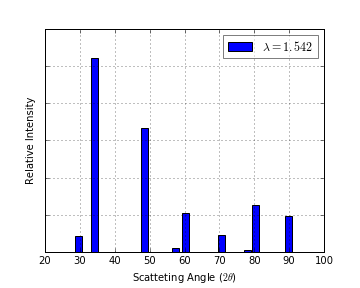

In [247]:
data = ipymd.data_input.crystal.Crystal()
data.setup_data(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na1+', 'Cl1-'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])

meta = data.get_meta_data()
atoms_df = data.get_atom_data()

wlambda = 1.542 # Angstrom ()
thetas, Is = compute_xrd(atoms_df,np.asarray([meta.a,meta.b,meta.c]),wlambda,
                         min2theta=20,max2theta=90)
plot_xrd_hist(thetas, Is,wlambda=wlambda,barwidth=2).display_plot()

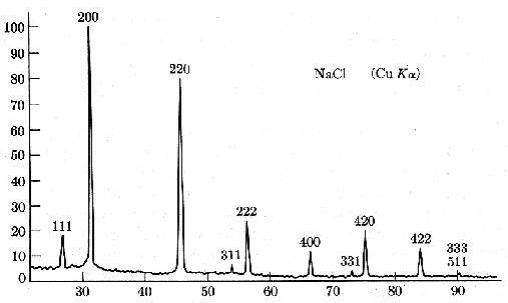

In [20]:
Image('xrd_nacl_Cu_kalpha.png',width=380)

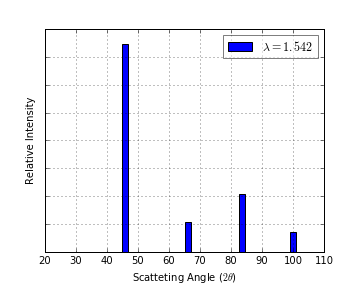

In [133]:
data = ipymd.data_input.crystal.Crystal()
data.setup_data(
    [[0,0,0]], ['Fe'], 
    229, cellpar=[2.866, 2.866, 2.866, 90, 90, 90], 
    repetitions=[5,5,5])

meta = data.get_meta_data()
atoms_df = data.get_atom_data()

wlambda = 1.542 # Angstrom ()
thetas, Is = compute_xrd(atoms_df,np.asarray([meta.a,meta.b,meta.c]),wlambda,
                         min2theta=20,max2theta=100)
plot_xrd_hist(thetas, Is,wlambda=wlambda,barwidth=2).display_plot()

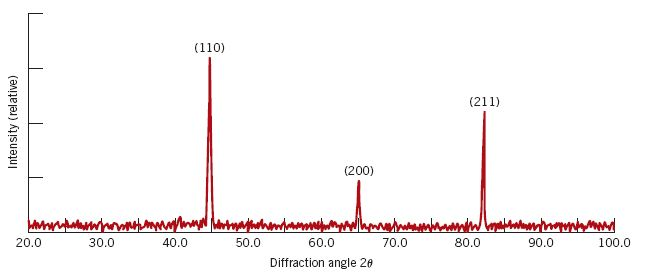

In [65]:
Image('xrd_fe_bcc_Cu_kalpha.png',width=360)

(8.4420000000000002, 13.025, 9.3559999999999999, 90.0, 124.98000000000002, 90.0)


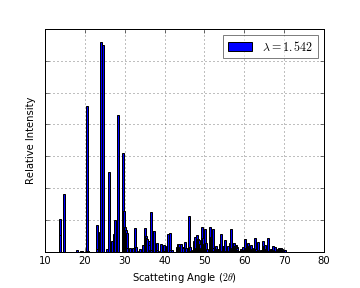

In [182]:
data = ipymd.data_input.cif.CIF()
data.setup_data(ipymd.get_data_path('sulfur_monoclinic.cif'))
meta = data.get_meta_data()
print ipymd.atom_analysis.basic.lattparams_bb(np.asarray([meta.a,meta.b,meta.c]))
atoms_df = data.get_atom_data()

wlambda = 1.542 # Angstrom ()
thetas, Is = compute_xrd(atoms_df,np.asarray([meta.a,meta.b,meta.c]),wlambda,
                         min2theta=10,max2theta=70,use_triclinic=True)
plot_xrd_hist(thetas, Is,bins=100000,wlambda=wlambda,barwidth=0.5).display_plot()

http://dx.doi.org/10.1021/ja01520a014

In [152]:
d = np.array([6.65, 6.32, 4.41, 3.79, 3.74, 3.29, 3.1, 3.04, 3.0, 2.6, 2.49, 
              2.46, 2.44, 2.18, 2.1, 1.932, 1.894, 1.872, 1.857, 1.786, 1.708, 
              1.679, 1.635, 1.599, 1.567, 1.452, 1.432])
theta2=2*np.degrees(np.arcsin(wlambda/(2*d)))
I = np.array([26, 4, 5, 13, 20, 100, 9, 12, 4, 2, 7, 6, 4, 3, 
              2, 1, 2, 3, 6, 3, 2, 1, 5, 2, 3, 17, 3])

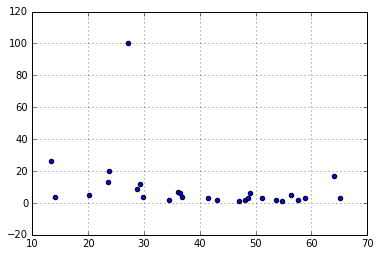

In [155]:
plt.scatter(theta2,I)
plt.grid()

(11.901999999999999, 6.859, 22.787000000000003, 90.0, 90.430000000000007, 90.0)


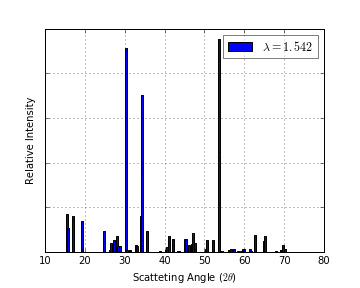

In [203]:
data = ipymd.data_input.cif.CIF()
data.setup_data(ipymd.get_data_path('pyr_4C_monoclinic.cif'))
meta = data.get_meta_data()
print ipymd.atom_analysis.basic.lattparams_bb(np.asarray([meta.a,meta.b,meta.c]))
atoms_df = data.get_atom_data()
new = ipymd.atom_manipulation.Atom_Manipulation(atoms_df)
new.change_type_variable('Fe','type','Fe2+')

wlambda = 1.542 # Angstrom ()
thetas, Is = compute_xrd(new.df,np.asarray([meta.a,meta.b,meta.c]),wlambda,
                         min2theta=10,max2theta=70,use_triclinic=True)
plot_xrd_hist(thetas, Is,bins=10000,wlambda=wlambda,barwidth=0.5).display_plot()

http://rruff.info/Pyrrhotite/R061127

In [177]:
from IPython.display import Image
Image(url=r'http://rruff.info/index.php/r=display_graph/sample_child_record_powder_id=2695/sample_id=2945/graph_type=powder/x_sort=/x_min=/x_max=')

## TODO

- Averaging over (thermal) phase space
- Calculation of structure factor coefficients from atom charge & type (rather than pre-defining ionic state)
- fast fourier transform?
- parallelization of fourier summation (http://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started)
- peak detection (http://www.diffpy.org/diffpy.srmise/tutorial/index.html)